In [3]:
import torch
from torch import nn 
import torchvision
from torchvision import transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
import random 
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"You are using : {device}")

You are using : cuda


In [86]:
BATCH_SIZE = 32
LR_RATE = 0.0001
NUM_EPOCHS = 30
z_dim = 128 #Bu bizim random noise değerimiz genelde 100 dür

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [ ]:
class CelebA(Dataset):
    def __init__(self, root_dir, transform=False, sample_ratio = 0.1) -> None:
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
        self.image_paths = random.sample(self.image_paths, int(len(self.image_paths) * sample_ratio)) #Orijinal veride 200000 tane veri var ben bunu 20000 e çektim
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx) -> Image:
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image  # Etiketler yok sadece görüntüyü döndür

In [8]:
data_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"  
dataset = CelebA(root_dir=data_dir, transform=transform)
dataset

In [9]:
dataloader = DataLoader(dataset=dataset, batch_size = BATCH_SIZE, shuffle = False)
dataloader

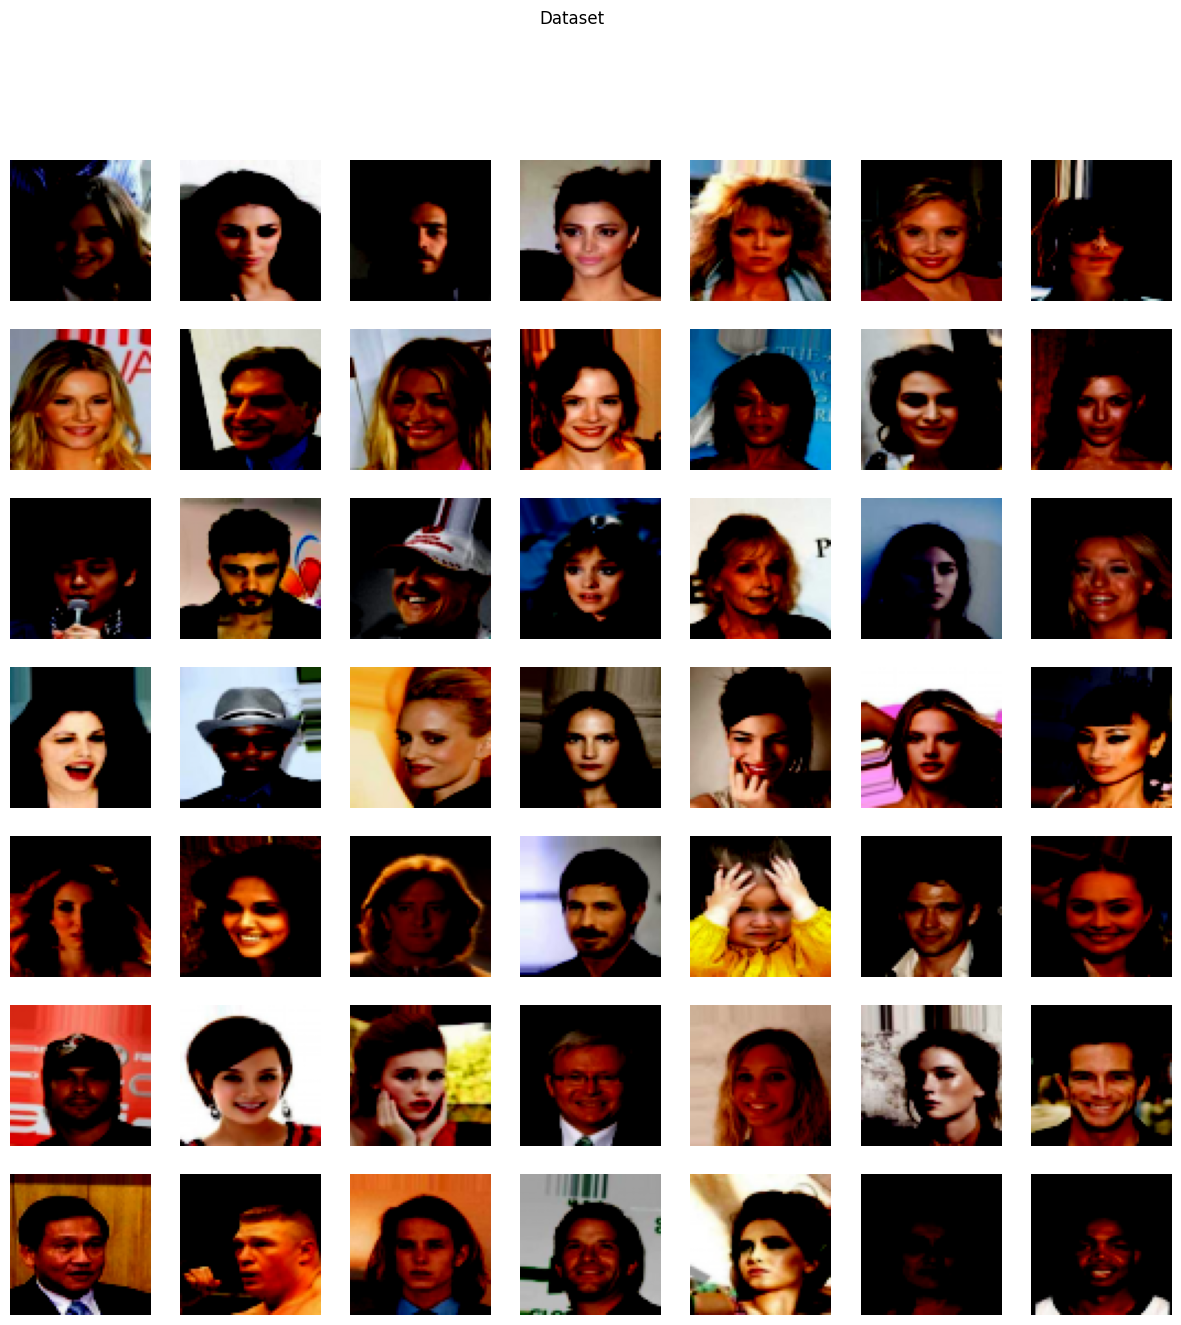

In [10]:
selected_imgs = []
for i in range(49):
    rand_num = random.randint(0, len(dataset)-1)
    selected_imgs.append(dataset[rand_num].permute(1,2,0))
fig, axes = plt.subplots(7, 7, figsize=(15, 15))

for i in range(7):
    for j in range(7):
        ax = axes[i, j]
        ax.imshow(selected_imgs[i * 7 + j]) 
        ax.axis('off') 

plt.suptitle("Dataset")
plt.show()

In [ ]:
#Burada ConvTranspose2d kullanıyoruz. Bu deconvolution olarak da bilinir. Konvolüsyon
#katmanının tersi işlem yapar. Upsample ile yüksek çözünürlüklü bir çıktı üretir. 
class Generator(nn.Module):
    def __init__(self, z_dim, feature_maps = 64) -> None:
        super(Generator, self).__init__()
        self.gen_block1 = self.create_transpose_block(z_dim, feature_maps * 8, stride = 1, padding = 0) 
        self.gen_block2 = self.create_transpose_block(feature_maps * 8, feature_maps * 4)
        self.gen_block3 = self.create_transpose_block(feature_maps * 4, feature_maps * 2)
        self.gen_block4 = self.create_transpose_block(feature_maps * 2, feature_maps)
        self.conv_transpose5 = nn.ConvTranspose2d(feature_maps, 3, 4, 2, 1, bias = False)
        self.tanh = nn.Tanh()
    def create_transpose_block(self, in_channels, out_channels, stride = 2, padding = 1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 4, stride = stride, padding = padding, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
    def forward(self, z) -> torch.Tensor:
        z = z.view(-1, z_dim, 1, 1)
        x = self.gen_block1(z)
        x = self.gen_block2(x)
        x = self.gen_block3(x)
        x = self.gen_block4(x)
        x = self.conv_transpose5(x)
        x = self.tanh(x)
        return x

In [76]:
Generator(z_dim)

Generator(
  (gen_block1): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (gen_block2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (gen_block3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (gen_block4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_transpo

In [93]:
class Discriminator(nn.Module):
    def __init__(self, num_feat=64):
        super(Discriminator, self).__init__()
        self.disc_block1 = self.create_disc_block(3, num_feat, bn = False)
        self.disc_block2 = self.create_disc_block(num_feat, num_feat * 2)
        self.disc_block3 = self.create_disc_block(num_feat * 2, num_feat * 4)
        self.disc_block4 = self.create_disc_block(num_feat * 4, num_feat * 8)
        self.conv5 = nn.Conv2d(num_feat * 8, 1, 4, 1, 0, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def create_disc_block(self, in_channels, out_channels, bn = True):
        if bn:
            return nn.Sequential(
               nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias = False),
               nn.BatchNorm2d(out_channels),
               nn.LeakyReLU(0.2, inplace = True),
           )
        else:
            return nn.Sequential(
               nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias = False),
               nn.LeakyReLU(0.2, inplace = True)
           )
           

    def forward(self, img):
        x = self.disc_block1(img)
        x = self.disc_block2(x)
        x = self.disc_block3(x)
        x = self.disc_block4(x)
        x = self.conv5(x)
        x = self.sigmoid(x)
        x = x.view(-1, 1)
        return x

In [95]:
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

In [96]:
#Makaledeki loss a en yakını BCE Loss tur. Onun önündeki eksi katsayısı ile normal fonksiyonu minimize edeceğimize eksilisini 
#maksimize ederiz
criterion = nn.BCELoss()
#İki farklı nöral ağımız olduğu için iki farklı optimizer olması gereklidir. Makalede optimizer da momentum kullanılmıştır
optimizer_G = torch.optim.SGD(G.parameters(), lr=LR_RATE,  momentum = 0.9)
optimizer_D = torch.optim.SGD(D.parameters(), lr=LR_RATE,  momentum = 0.9)

In [97]:
writer = SummaryWriter(log_dir='runs/dcgan_experiment')

for epoch in range(NUM_EPOCHS):
    for index, real_img in enumerate(dataloader):
        batch_size = real_img.shape[0]
        real_img  = real_img.view(batch_size, 3, 64, 64).to(device)

        #Discriminator 
        z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_img = G(z)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        D_real = D(real_img)
        D_fake = D(fake_img)
        D_loss = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

        optimizer_D.zero_grad()
        D_loss.backward(retain_graph = True)
        optimizer_D.step()

        #Generator
        G_fake = D(fake_img)
        G_loss = criterion(G_fake, real_labels)  
        
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()
    if index % 5 == 0:  
            with torch.no_grad():
                generated_images = G(z)  
            grid = make_grid(generated_images, nrow=4, normalize=True, scale_each=True)
            writer.add_image(f'Generated Images/Epoch_{epoch+1}_Batch_{index}', grid, epoch * len(dataloader) + index)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}")

Epoch [1/30], D Loss: 0.1342, G Loss: 3.3508
Epoch [2/30], D Loss: 0.0688, G Loss: 4.2500
Epoch [3/30], D Loss: 0.0422, G Loss: 4.5622
Epoch [4/30], D Loss: 0.9325, G Loss: 3.4616
Epoch [5/30], D Loss: 0.0051, G Loss: 6.3511
Epoch [6/30], D Loss: 0.7732, G Loss: 4.9882
Epoch [7/30], D Loss: 0.0146, G Loss: 5.3016
Epoch [8/30], D Loss: 0.0188, G Loss: 5.2021
Epoch [9/30], D Loss: 0.0116, G Loss: 5.5961
Epoch [10/30], D Loss: 0.0153, G Loss: 5.7532
Epoch [11/30], D Loss: 0.0198, G Loss: 4.5058
Epoch [12/30], D Loss: 0.0121, G Loss: 7.4931
Epoch [13/30], D Loss: 0.0026, G Loss: 10.4227
Epoch [14/30], D Loss: 0.0268, G Loss: 6.0723
Epoch [15/30], D Loss: 3.2007, G Loss: 6.1220
Epoch [16/30], D Loss: 0.7550, G Loss: 3.5350
Epoch [17/30], D Loss: 0.0231, G Loss: 5.2953
Epoch [18/30], D Loss: 0.6685, G Loss: 4.9367
Epoch [19/30], D Loss: 0.1173, G Loss: 3.9580
Epoch [20/30], D Loss: 0.1968, G Loss: 3.1814
Epoch [21/30], D Loss: 0.3010, G Loss: 4.7926
Epoch [22/30], D Loss: 0.0003, G Loss: 8.7